In [54]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib
import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier

from nltk.sentiment import SentimentIntensityAnalyzer

In [55]:
plt.style.use('ggplot')
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [56]:
df = pd.read_csv("/content/twitter_training.csv")
df.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [57]:
df.columns = ["ID", "Name", "Sentiment", "Comment"]
df.head()

,ID,Name,Sentiment,Comment
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [58]:
print("Ukuran dataset:", df.shape)

Ukuran dataset: (74681, 4)


In [59]:
print("\nInfo kolom:")
df.info()


Info kolom:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         74681 non-null  int64 
 1   Name       74681 non-null  object
 2   Sentiment  74681 non-null  object
 3   Comment    73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [60]:
print("\nCek Nilai Kosong:")
print(df.isnull().sum())


Cek Nilai Kosong:
ID             0
Name           0
Sentiment      0
Comment      686
dtype: int64


In [61]:
print("\nJumlah komentar unik:", df['Comment'].nunique())
print("Jumlah komentar duplikat:", df.duplicated('Comment').sum())


Jumlah komentar unik: 69490
Jumlah komentar duplikat: 5190


In [62]:
df.describe()
print(df.describe())

                 ID
count  74681.000000
mean    6432.640149
std     3740.423819
min        1.000000
25%     3195.000000
50%     6422.000000
75%     9601.000000
max    13200.000000


##**Cleaning Data**

In [63]:
def clean_text(text):
    text = re.sub(r"http\S+|@\w+|#\w+|[^\w\s]", "", str(text))
    return text.lower().strip()

In [64]:
df = df.dropna()
print("\nSetelah menghapus nilai kosong:")
print(df.isnull().sum())


Setelah menghapus nilai kosong:
ID           0
Name         0
Sentiment    0
Comment      0
dtype: int64


In [65]:
df = df.drop_duplicates(subset="Comment", keep="first")
print("\nSetelah menghapus nilai duplikat:")
print(df.duplicated().sum())


Setelah menghapus nilai duplikat:
0


In [66]:
df['Sentiment'] = df['Sentiment'].str.lower()
df['cleaned'] = df['Comment'].apply(clean_text)

<ipython-input-66-c274d49bb346>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Sentiment'] = df['Sentiment'].str.lower()


In [67]:
df.head()

,ID,Name,Sentiment,Comment,cleaned
0,2401,Borderlands,positive,I am coming to the borders and I will kill you...,i am coming to the borders and i will kill you...
1,2401,Borderlands,positive,im getting on borderlands and i will kill you ...,im getting on borderlands and i will kill you all
2,2401,Borderlands,positive,im coming on borderlands and i will murder you...,im coming on borderlands and i will murder you...
3,2401,Borderlands,positive,im getting on borderlands 2 and i will murder ...,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,positive,im getting into borderlands and i can murder y...,im getting into borderlands and i can murder y...


#**DATA EXPLORATION**

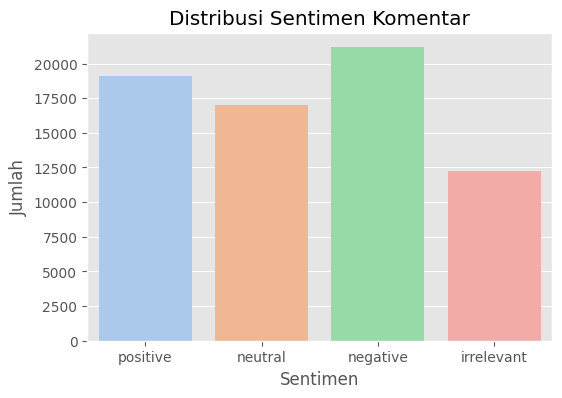

In [101]:
plt.figure(figsize=(6,4))

sns.countplot(data=df, x='Sentiment', hue='Sentiment', palette='pastel', legend=False)
plt.title('Distribusi Sentimen Komentar')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()

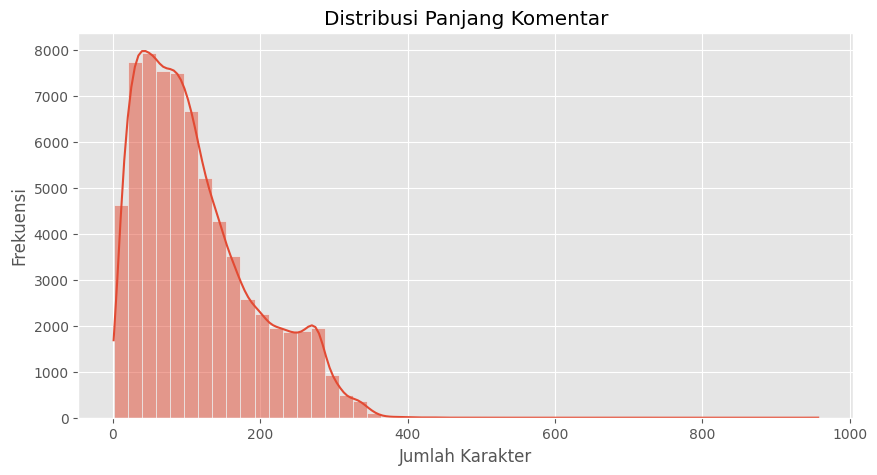

In [68]:
df.loc[:, 'comment_length'] = df['Comment'].astype(str).apply(len)

plt.figure(figsize=(10,5))
sns.histplot(df['comment_length'], bins=50, kde=True)
plt.title('Distribusi Panjang Komentar')
plt.xlabel('Jumlah Karakter')
plt.ylabel('Frekuensi')
plt.show()

##**Vader Sentimen Analysis**

In [69]:
df["vader_score"] = df["cleaned"].apply(lambda x: sia.polarity_scores(x)["compound"])
df["vader_sentiment"] = df["vader_score"].apply(lambda s: "positive" if s >= 0.05 else "negative" if s <= -0.05 else "neutral")

In [70]:
X = df["cleaned"]
y = df["Sentiment"]

tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(X)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

#**PERBANDINGAN MODEL**

In [72]:
models = {
    "LinearSVC": LinearSVC(random_state=42, max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42, n_estimators=100),
    "AdaBoost": AdaBoostClassifier(random_state=42, n_estimators=100),
    "SGD Classifier": SGDClassifier(random_state=42, max_iter=1000, tol=1e-3),
    "MLP Classifier": MLPClassifier(random_state=42, max_iter=300),
    "Dummy Classifier": DummyClassifier(strategy="most_frequent")
}
results = {}


--- Evaluasi Model: LinearSVC ---
              precision    recall  f1-score   support

  irrelevant       0.70      0.59      0.64      2443
    negative       0.75      0.80      0.77      4233
     neutral       0.68      0.66      0.67      3409
    positive       0.71      0.75      0.73      3813

    accuracy                           0.72     13898
   macro avg       0.71      0.70      0.70     13898
weighted avg       0.71      0.72      0.71     13898



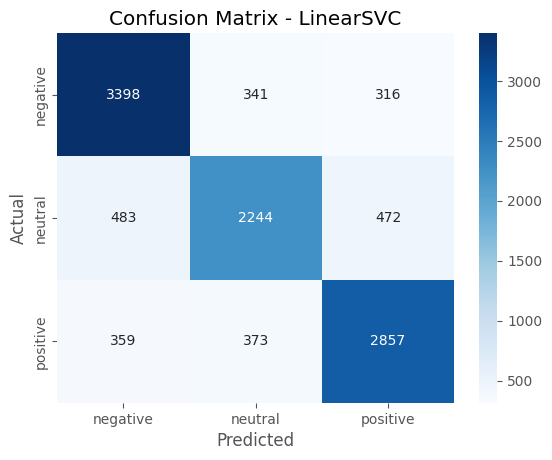


--- Evaluasi Model: Naive Bayes ---
              precision    recall  f1-score   support

  irrelevant       0.75      0.35      0.48      2443
    negative       0.62      0.82      0.71      4233
     neutral       0.69      0.54      0.60      3409
    positive       0.62      0.75      0.68      3813

    accuracy                           0.65     13898
   macro avg       0.67      0.61      0.62     13898
weighted avg       0.66      0.65      0.63     13898



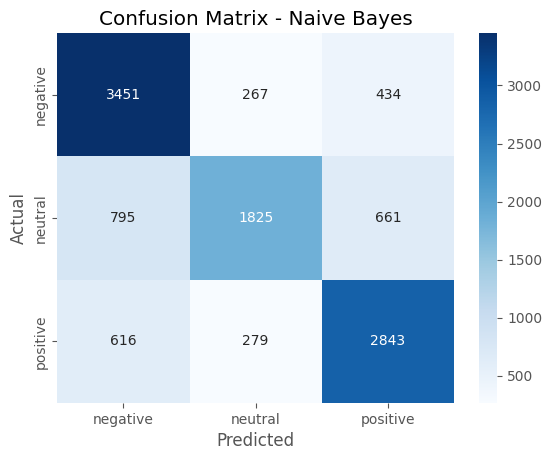


--- Evaluasi Model: Logistic Regression ---
              precision    recall  f1-score   support

  irrelevant       0.69      0.53      0.60      2443
    negative       0.72      0.80      0.76      4233
     neutral       0.66      0.64      0.65      3409
    positive       0.69      0.73      0.71      3813

    accuracy                           0.70     13898
   macro avg       0.69      0.68      0.68     13898
weighted avg       0.69      0.70      0.69     13898



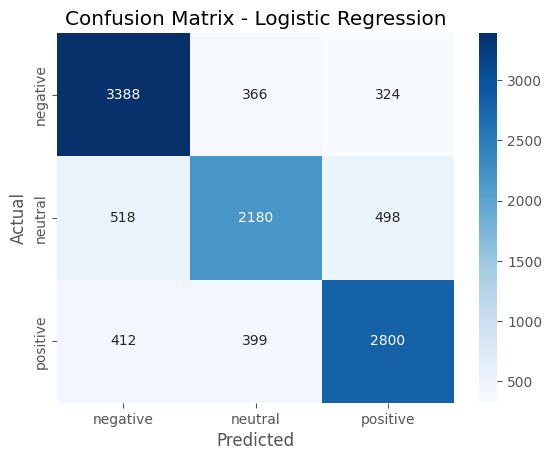


--- Evaluasi Model: Random Forest ---
              precision    recall  f1-score   support

  irrelevant       0.95      0.80      0.87      2443
    negative       0.87      0.93      0.90      4233
     neutral       0.88      0.89      0.89      3409
    positive       0.89      0.91      0.90      3813

    accuracy                           0.89     13898
   macro avg       0.90      0.88      0.89     13898
weighted avg       0.89      0.89      0.89     13898



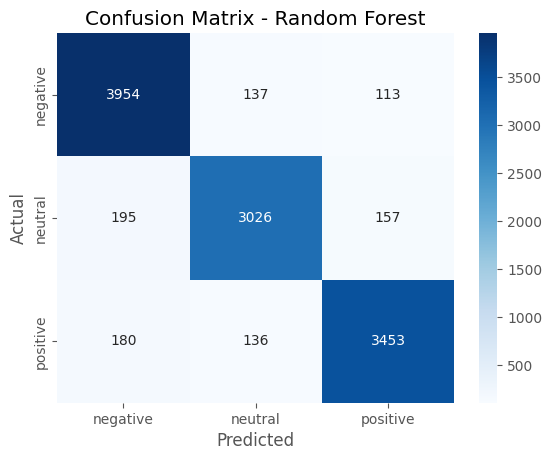


--- Evaluasi Model: KNN ---
              precision    recall  f1-score   support

  irrelevant       0.85      0.89      0.87      2443
    negative       0.89      0.92      0.90      4233
     neutral       0.89      0.89      0.89      3409
    positive       0.92      0.86      0.89      3813

    accuracy                           0.89     13898
   macro avg       0.89      0.89      0.89     13898
weighted avg       0.89      0.89      0.89     13898



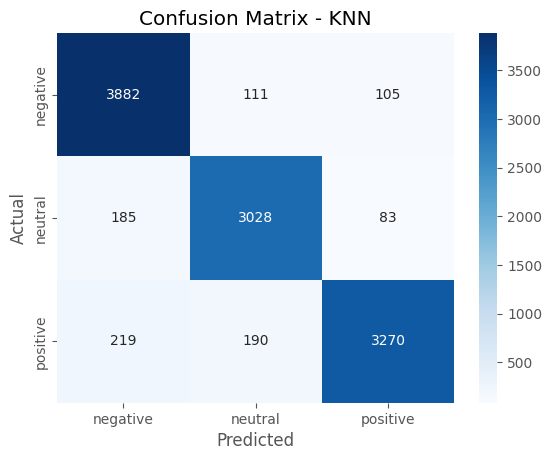


--- Evaluasi Model: Decision Tree ---
              precision    recall  f1-score   support

  irrelevant       0.69      0.64      0.67      2443
    negative       0.76      0.76      0.76      4233
     neutral       0.71      0.73      0.72      3409
    positive       0.74      0.75      0.75      3813

    accuracy                           0.73     13898
   macro avg       0.72      0.72      0.72     13898
weighted avg       0.73      0.73      0.73     13898



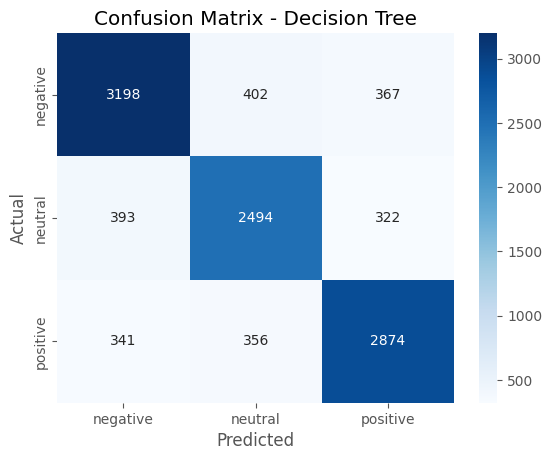


--- Evaluasi Model: Gradient Boosting ---
              precision    recall  f1-score   support

  irrelevant       0.68      0.20      0.31      2443
    negative       0.48      0.80      0.60      4233
     neutral       0.60      0.40      0.48      3409
    positive       0.58      0.59      0.58      3813

    accuracy                           0.54     13898
   macro avg       0.59      0.50      0.50     13898
weighted avg       0.57      0.54      0.52     13898



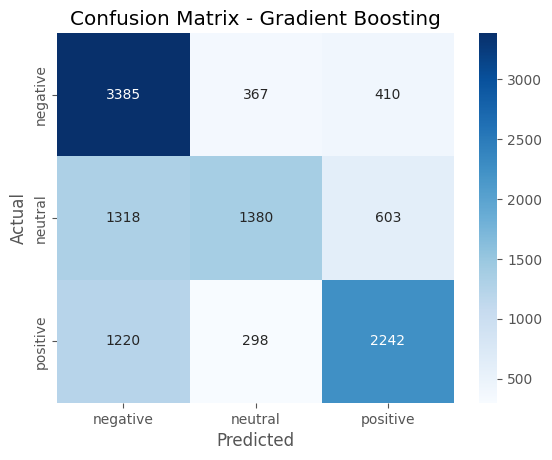


--- Evaluasi Model: AdaBoost ---
              precision    recall  f1-score   support

  irrelevant       0.92      0.05      0.09      2443
    negative       0.35      0.92      0.50      4233
     neutral       0.61      0.11      0.18      3409
    positive       0.56      0.29      0.38      3813

    accuracy                           0.39     13898
   macro avg       0.61      0.34      0.29     13898
weighted avg       0.57      0.39      0.32     13898



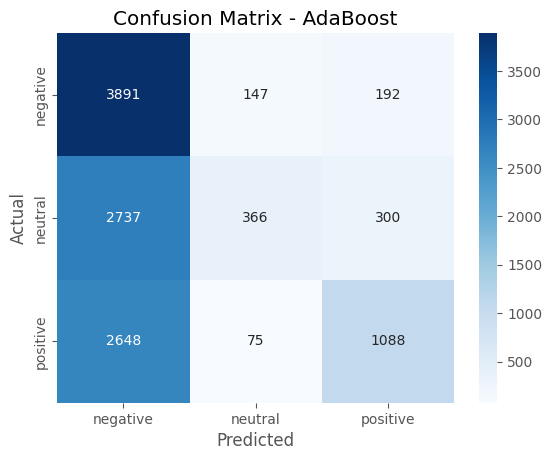


--- Evaluasi Model: SGD Classifier ---
              precision    recall  f1-score   support

  irrelevant       0.77      0.32      0.45      2443
    negative       0.64      0.82      0.72      4233
     neutral       0.65      0.57      0.61      3409
    positive       0.64      0.75      0.69      3813

    accuracy                           0.65     13898
   macro avg       0.68      0.62      0.62     13898
weighted avg       0.67      0.65      0.64     13898



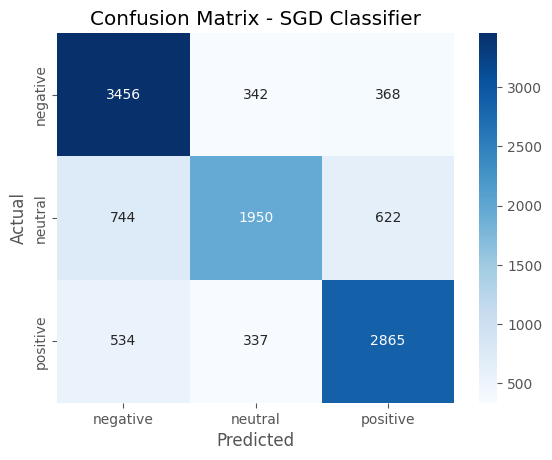


--- Evaluasi Model: MLP Classifier ---
              precision    recall  f1-score   support

  irrelevant       0.87      0.85      0.86      2443
    negative       0.91      0.91      0.91      4233
     neutral       0.88      0.87      0.87      3409
    positive       0.88      0.90      0.89      3813

    accuracy                           0.89     13898
   macro avg       0.88      0.88      0.88     13898
weighted avg       0.89      0.89      0.89     13898



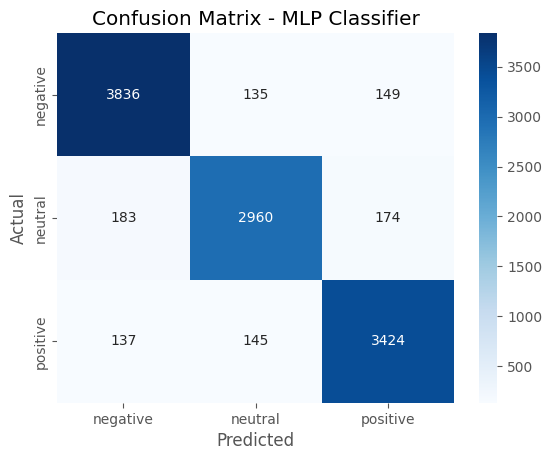


--- Evaluasi Model: Dummy Classifier ---
              precision    recall  f1-score   support

  irrelevant       0.00      0.00      0.00      2443
    negative       0.30      1.00      0.47      4233
     neutral       0.00      0.00      0.00      3409
    positive       0.00      0.00      0.00      3813

    accuracy                           0.30     13898
   macro avg       0.08      0.25      0.12     13898
weighted avg       0.09      0.30      0.14     13898



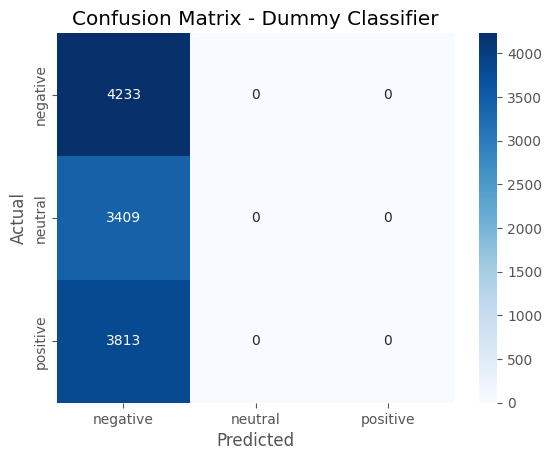

In [73]:
results = {}

for name, model in models.items():
    print(f"\n--- Evaluasi Model: {name} ---")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    results[name] = {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1-Score": f1}

    print(classification_report(y_test, y_pred, zero_division=0))

    cm = confusion_matrix(y_test, y_pred, labels=['negative', 'neutral', 'positive'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['negative', 'neutral', 'positive'],
                yticklabels=['negative', 'neutral', 'positive'])
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [74]:
results_df = pd.DataFrame(results).T.sort_values(by="F1-Score", ascending=False)
print("\nPerbandingan Performa Model:")
display(results_df.style.background_gradient(cmap="Blues").format("{:.2%}"))


Perbandingan Performa Model:


,Accuracy,Precision,Recall,F1-Score
Random Forest,89.21%,89.41%,89.21%,89.17%
KNN,88.98%,89.08%,88.98%,88.98%
MLP Classifier,88.55%,88.54%,88.55%,88.54%
Decision Tree,72.95%,72.93%,72.95%,72.92%
LinearSVC,71.51%,71.37%,71.51%,71.30%
Logistic Regression,69.54%,69.42%,69.54%,69.20%
SGD Classifier,65.19%,66.54%,65.19%,63.75%
Naive Bayes,64.53%,66.13%,64.53%,63.24%
Gradient Boosting,53.95%,57.36%,53.95%,51.68%
AdaBoost,39.33%,57.17%,39.33%,31.85%


##**RANDOM FOREST**
Menggunakan model Random Forest dikarenakan memiliki hasil akurasi yang paling tinggi.

In [86]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  irrelevant       0.95      0.80      0.87      2443
    negative       0.87      0.93      0.90      4233
     neutral       0.88      0.89      0.89      3409
    positive       0.89      0.91      0.90      3813

    accuracy                           0.89     13898
   macro avg       0.90      0.88      0.89     13898
weighted avg       0.89      0.89      0.89     13898



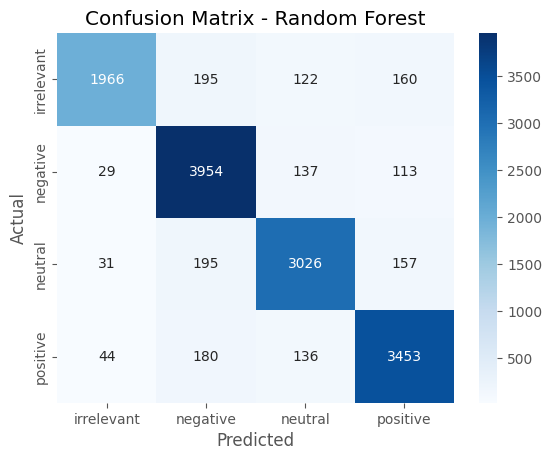

In [87]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [88]:
# Evaluasi
print(f"Akurasi       : {accuracy_score(y_test, y_pred):.2f}")
print(f"Precision     : {precision_score(y_test, y_pred, average='weighted'):.2f}")
print(f"Recall        : {recall_score(y_test, y_pred, average='weighted'):.2f}")
print(f"F1-Score      : {f1_score(y_test, y_pred, average='weighted'):.2f}")

Akurasi       : 0.89
Precision     : 0.89
Recall        : 0.89
F1-Score      : 0.89


#**Penyimpanan Model**

In [89]:
model = joblib.load('sentiment_model.pkl')
vectorizer = joblib.load('vectorizer.pkl')

##**Prediksi komentar manual**

In [90]:
# Fungsi prediksi
def predict_sentiment(comment):
    cleaned = clean_text(comment)
    vect = vectorizer.transform([cleaned])
    pred = model.predict(vect)[0]
    return pred

In [98]:
# Input komentar dari user
user_input = input("Input Komentar: ")
result = predict_sentiment(user_input)
print(f"\nSentimen prediksi: {result}")

Input Comment: 	imma is probably playing a bit of borderland tps. That will be fun.

Predict Sentiment: positive
